In [322]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [323]:
# Hanrui's updated dataset
sps = pd.read_csv("../data/sps.csv")

In [324]:
sps.drop(columns=['dbsource', 'formulary_drug_cd_list', 'admission_location', 'admittime', 'dischtime',
                  'edregtime', 'edouttime', 'diagnosis', 'latest_gcs_time', 'comorbidities', 'proc.icd9_list'], inplace=True, errors='ignore')

# figure these columns out later
sps.drop(columns=['gcs_verbal', 'gcs_motor', 'gcs_eye', 'language', 'drug.Miscellaneous', 'diag.Missing', 'gcs_total'], inplace=True, errors='ignore')

# drop patients with no provided age
sps.dropna(subset=["age.at.admit"], inplace=True)
#sps.dropna(subset=["gcs_total"], inplace=True)


In [325]:
# one hot encoding for these columns
df = pd.get_dummies(sps, columns=['gender', 'admission_type', 'insurance', 'religion', 'marital_status', 'ethnicity', 'discharge_location', 'intervention.group'])

ethnicity_groups = {
    'ethnicity_WHITE': ['ethnicity_WHITE', 'ethnicity_WHITE - BRAZILIAN', 'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_WHITE - RUSSIAN', 'ethnicity_MIDDLE EASTERN'],
    'ethnicity_BLACK': ['ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_BLACK/CAPE VERDEAN', 'ethnicity_BLACK/HAITIAN'],
    'ethnicity_HISPANIC_LATINO': ['ethnicity_HISPANIC OR LATINO', 'ethnicity_HISPANIC/LATINO - COLOMBIAN', 'ethnicity_HISPANIC/LATINO - DOMINICAN', 'ethnicity_HISPANIC/LATINO - PUERTO RICAN'],
    'ethnicity_ASIAN': ['ethnicity_ASIAN', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - VIETNAMESE'],
    'ethnicity_OTHER': [ 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_MULTI RACE ETHNICITY', 'ethnicity_OTHER'],
    'ethnicity_UNKNOWN': [ 'ethnicity_PATIENT DECLINED TO ANSWER', 'ethnicity_UNABLE TO OBTAIN', 'ethnicity_UNKNOWN/NOT SPECIFIED']
}

# Combine columns based on the mappings
for new_col, cols_to_merge in ethnicity_groups.items():
    df[new_col] = df[cols_to_merge].any(axis=1).astype(int)

# Drop the original detailed ethnicity columns
all_original_cols = [col for cols in ethnicity_groups.values() for col in cols]
df = df.drop(columns=all_original_cols)


In [326]:
# survived if > a certain value
df['survived_90'] = df['survival_days'] > 90

# doesn't work with NA columns
incomplete_cols = df.columns[df.isna().sum() != 0]
complete_cols = df.columns[df.isna().sum() == 0]

df[incomplete_cols] = df[incomplete_cols].fillna(0)

# split into cov/predictors and target (also some identifiers removed from X)
#X = df[complete_cols].drop(columns=['subject_id', 'survival_days', 'survived_90', 'event'])
X = df.drop(columns=['subject_id', 'survival_days', 'survived_90', 'event'])
y = df['survived_90']

In [327]:
complete_cols

Index(['subject_id', 'diag.H5', 'diag.I1', 'diag.S1', 'diag.H6', 'diag.M1',
       'diag.H4', 'diag.N1', 'diag.H3', 'diag.H1', 'diag.H2', 'survival_days',
       'event', 'age.at.admit', 'gender_F', 'gender_M',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY',
       'admission_type_URGENT', 'insurance_Government', 'insurance_Medicaid',
       'insurance_Medicare', 'insurance_Private', 'insurance_Self Pay',
       'religion_BUDDHIST', 'religion_CATHOLIC',
       'religion_CHRISTIAN SCIENTIST', 'religion_EPISCOPALIAN',
       'religion_GREEK ORTHODOX', 'religion_HINDU',
       'religion_JEHOVAH'S WITNESS', 'religion_JEWISH', 'religion_MUSLIM',
       'religion_NOT SPECIFIED', 'religion_OTHER',
       'religion_PROTESTANT QUAKER', 'religion_ROMANIAN EAST. ORTH',
       'religion_UNOBTAINABLE', 'marital_status_DIVORCED',
       'marital_status_MARRIED', 'marital_status_SEPARATED',
       'marital_status_SINGLE', 'marital_status_UNKNOWN (DEFAULT)',
       'marital_status_WIDOWE

Accuracy: 0.7205882352941176

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76        79
           1       0.67      0.67      0.67        57

    accuracy                           0.72       136
   macro avg       0.71      0.71      0.71       136
weighted avg       0.72      0.72      0.72       136


Confusion Matrix:
 [[60 19]
 [19 38]]


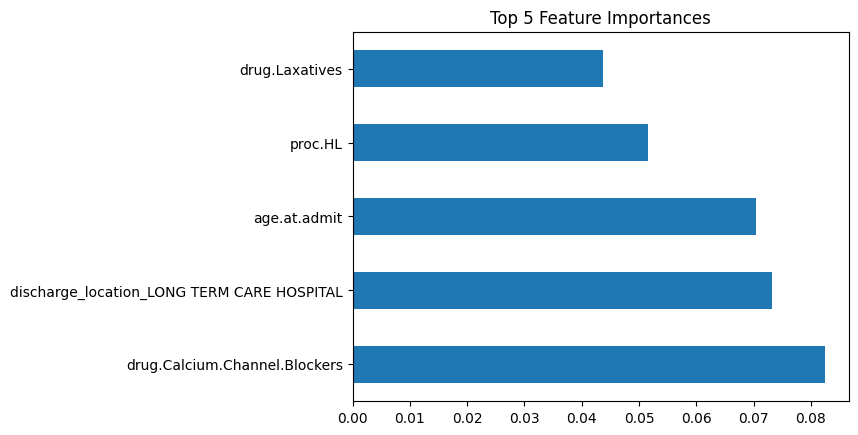

In [335]:
# Preprocessing


# Encode categorical variables if needed
le = LabelEncoder()
y = le.fit_transform(y)

#y_train = le.fit_transform(y_train)
#y_test = le.fit_transform(y_test)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    criterion='gini',      # Splitting criterion
    max_depth=None,        # Maximum depth of trees
    min_samples_split=2,   # Minimum samples required to split a node
    min_samples_leaf=1,    # Minimum samples required at each leaf node
    max_features='sqrt',   # Number of features to consider at each split
    random_state=7
)

rf = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages (trees)
    learning_rate=0.1,      # Shrinks contribution of each tree
    max_depth=3,            # Maximum depth of the individual estimators
    min_samples_split=2,    # Minimum samples to split an internal node
    min_samples_leaf=1,     # Minimum samples at a leaf node
    max_features='sqrt',    # Features considered at each split
    random_state=713
)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance visualization
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(5).plot(kind='barh')
plt.title('Top 5 Feature Importances')
plt.show()

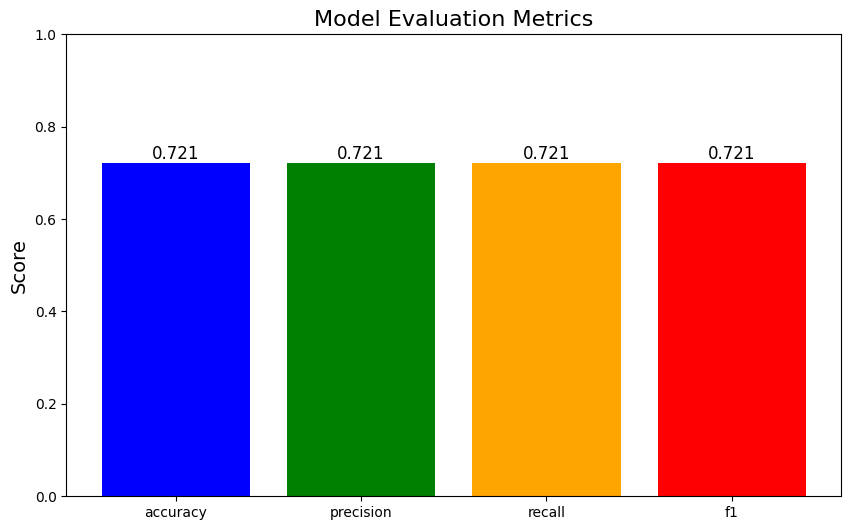

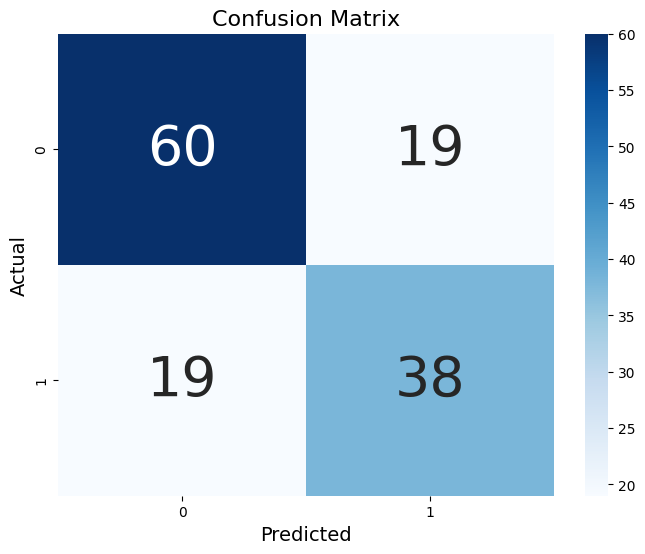

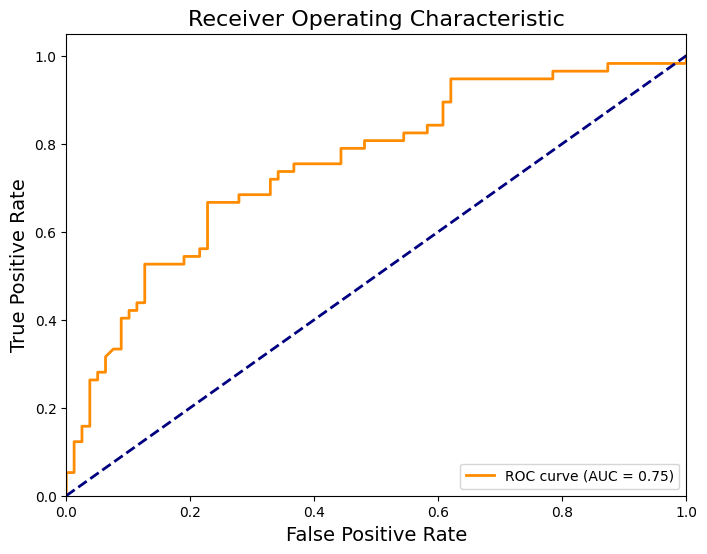

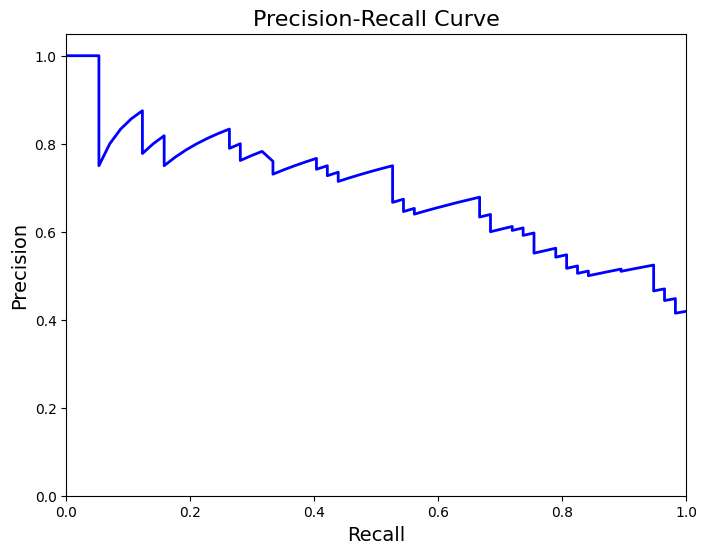

In [336]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns

# 1. Basic Accuracy Plot (for classification report metrics)
metrics = ['accuracy', 'precision', 'recall', 'f1']
scores = [
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
    f1_score(y_test, y_pred, average='weighted')
]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylim(0, 1)
plt.ylabel('Score', fontsize=14)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=12)

plt.show()

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 40})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# 3. ROC Curve (for binary classification)
if len(le.classes_) == 2:
    y_prob = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, 
                                            rf.predict_proba(X_test)[:, 1] if len(le.classes_) == 2 
                                            else rf.predict_proba(X_test).max(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [334]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} days")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f} days")
print(f"R²: {r2:.4f}")

MAE: 0.27 days
MSE: 0.27
RMSE: 0.52 days
R²: -0.1175


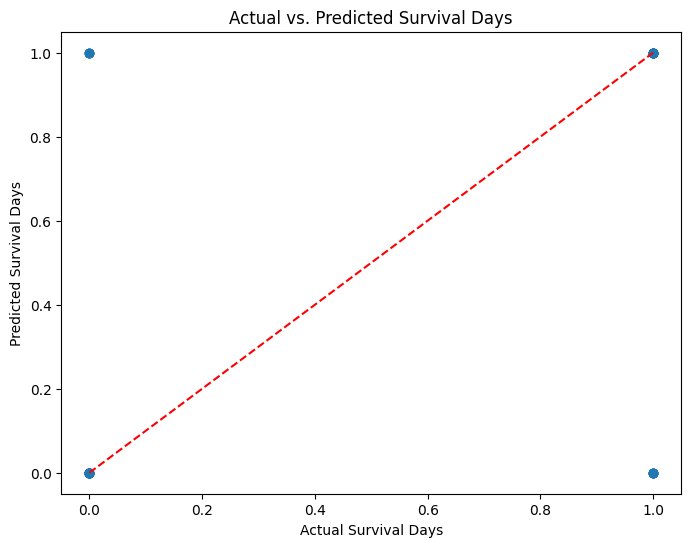

In [320]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Survival Days")
plt.ylabel("Predicted Survival Days")
plt.title("Actual vs. Predicted Survival Days")
plt.show()